# IFM Generation: CIFAR10 32x32

In [1]:
import torch
import torchvision

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import wandb
import sys
sys.path.append("/trinity/home/a.kolesov/EFM/")
from src.models import DDPM, ExponentialMovingAverage
from src.ifm_field import IFM
from src.utils import Config, optimization_manager, random_color

## 1. Base Config

In [10]:
config = Config()

 
config.L = 20. # important parameter
config.SCALE = 1.
config.K =  math.pi/config.L
config.D = math.pi/(2*config.K)
config.device = 'cuda'
config.experiment = 'generation'

config.data = Config()
config.data.name = 'CIFAR10'
config.data.num_channels = 3
config.data.img_resize = 32
config.data.image_size=32
config.data.centered = True
config.DIM = config.data.num_channels*config.data.image_size*config.data.image_size + 1

config.p = Config()
config.p.x_loc = 0.

config.q = Config()
config.q.x_loc = config.L

config.training = Config()
config.training.small_batch_size =64 # important parameter
config.training.batch_size =256      # important parameter
config.training.field_type = "Shifted"
config.training.plan_type = "Independent"
config.training.field_form = "exponential"
config.training.n_iters = 1_000_000
config.training.sde = 'poisson'
config.training.eval_freq = 1_000
config.training.snapshot_freq = 5_000
config.training.sigma_end = 0.1
config.training.M = 191 # important parameter
config.training.tau = 0.03  
config.training.epsilon = 1e-3 # important parameter
config.training.interpolation = 'Uniform'
config.training.noised_interpolation=False
config.training.restrict_M = False
config.training.gamma = 5. # important parameter

config.model  = Config()
config.model.name = 'ncsnpp'
config.model.scale_by_sigma = False
config.model.ema_rate = 0.9999
config.model.normalization = 'GroupNorm'
config.model.nonlinearity = 'swish'
config.model.nf = 128
config.model.ch_mult = (1, 2, 2, 2)
config.model.num_res_blocks = 4
config.model.attn_resolutions = (16,)
config.model.resamp_with_conv = True
config.model.conditional = True
config.model.fir = False
config.model.fir_kernel = [1, 3, 3, 1]
config.model.skip_rescale = True
config.model.resblock_type = 'biggan'
config.model.progressive = 'none'
config.model.progressive_input = 'none'
config.model.progressive_combine = 'sum'
config.model.attention_type = 'ddpm'
config.model.init_scale = 0.
config.model.fourier_scale = 16
config.model.embedding_type = 'positional'
config.model.conv_size = 3
config.model.dropout = 0.1

config.optim  = Config()
config.optim.weight_decay = 0
config.optim.optimizer = 'Adam'
config.optim.lr = 2e-4
config.optim.beta1 = 0.9
config.optim.eps = 1e-8 
config.optim.warmup = 5000  
config.optim.grad_clip = 1.

config.ode = Config()
config.ode.gamma = 1e-7
config.ode.step = 0.25

config.sampling = Config()
config.sampling.method = 'ode'
config.sampling.ode_solver = 'rk45'
config.sampling.N = 100
config.sampling.z_max = config.L# - config.training.epsilon
config.sampling.z_min = config.training.epsilon
config.sampling.upper_norm = 3000
config.sampling.z_exp=1
config.sampling.vs = False
config.sampling.visual_iterations=10

## 2. Data

In [11]:
TRANSFORM = torchvision.transforms.Compose([
    torchvision.transforms.Resize(config.data.img_resize),
    torchvision.transforms.ToTensor()
])


train_data = torchvision.datasets.CIFAR10(root='/trinity/home/a.kolesov/data/CIFAR10/',
                                        train=True, download=True, transform=TRANSFORM)
eval_data = torchvision.datasets.CIFAR10(root='/trinity/home/a.kolesov/data/CIFAR10/',
                                        train=False, download=True, transform=TRANSFORM)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.training.batch_size,
                                           shuffle=True)
eval_loader =  torch.utils.data.DataLoader(eval_data, batch_size=config.training.batch_size, 
                                           shuffle=True)

train_iter = iter(train_loader)
eval_iter = iter(eval_loader)

Files already downloaded and verified
Files already downloaded and verified


## 3. Models

In [12]:
net = DDPM(config).to(config.device)
params = net.parameters()
optimizer = torch.optim.Adam(params,
                       lr=config.optim.lr, betas=(config.optim.beta1, 0.999), eps=config.optim.eps,
                       weight_decay=config.optim.weight_decay)

ema = ExponentialMovingAverage(net.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=net, ema=ema, step=0)
optimize_fn = optimization_manager(config)

## 4. Training

In [13]:
config.name_exp = f"CIFAR10Generation_L={config.L}_sc={config.SCALE}_BS_{config.training.batch_size}_\
SBS={config.training.small_batch_size}_plan_{config.training.plan_type}_\
Int={config.training.interpolation}"

  0%|          | 0/1000001 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

KeyboardInterrupt: 

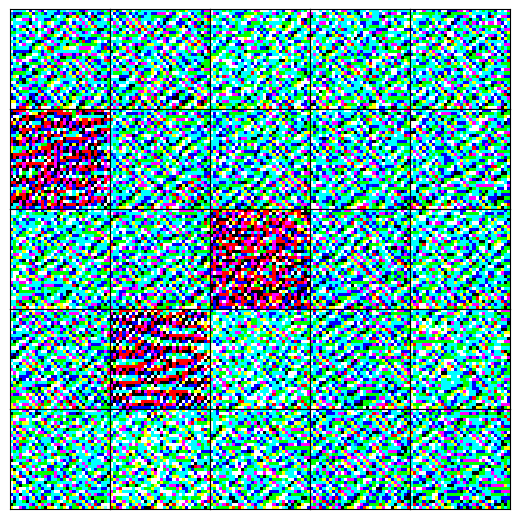

In [14]:
ifm = IFM(config)
net, state = ifm.train(train_loader, eval_loader,
                       net, optimizer, optimize_fn,
                       state)